# Supervised Learning of a Burgers predictor

Let $\mathcal{P}$ be the transient simulation operator (=time stepper)
associated with the 1d Burgers equation under a certain configuration. The goal
of this notebook is to learn an **autogressive neural operator** ($\approx$ a
neural predictor) $f_\theta$ that mimics the behavior of $\mathcal{P}$, i.e.,
$f_\theta \approx \mathcal{P}$.

The Optimization shall be in terms of a **one-step supervised loss**

$$
L(\theta) = \mathbb{E}_{u_h \propto \mathcal{D}} \left[\text{MSE}(f_\theta(u_h), \mathcal{P}(u_h)) \right]
$$

with $\mathcal{D}$ being a dataset of sample trajectories created with the
reference solver $\mathcal{P}$.

This notebook contains the following sections:

1. Data Generation:
    1. Instantiating a distribution of initial conditions
    2. Sample the distribution for a set of training and validation/testing initial conditions
    3. Rollout the initial conditions of both sets by means of the reference solver $\mathcal{P}$
2. Model Definition (just a simple periodic convolutional network)
3. Training
4. Evaluation

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import equinox as eqx
import optax
from typing import List
from tqdm.autonotebook import tqdm

/tmp/ipykernel_693928/2678998196.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import exponax as ex

Below are constants we fix for the training; feel free to play around with them

In [3]:
DOMAIN_EXTENT = 1.0
NUM_POINTS = 100
DT = 0.01
DIFFUSIVITY = 0.03

INITIAL_CONDITION_WAVENUMBER_CUTOFF = 5

TRAIN_NUM_SAMPLES = 200
TRAIN_TEMPORAL_HORIZON = 50
TRAIN_SEED = 0

INIT_SEED = 1337

OPTIMIZER = optax.adam(optax.exponential_decay(1e-4, 500, 0.90))
NUM_EPOCHS = 50
BATCH_SIZE = 100
SHUFFLE_SEED = 42

VAL_NUM_SAMPLES = 20
VAL_TEMPORAL_HORIZON = 100
VAL_SEED = 773

Instantiate the reference stepper $\mathcal{P}$ as a Burgers solver in 1d.

In [4]:
reference_stepper = ex.Burgers(
    1, DOMAIN_EXTENT, NUM_POINTS, DT, diffusivity=DIFFUSIVITY
)

2024-03-01 10:36:12.090159: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## 1. Data Generation

The initial condition distribution are all functions described by the first
`WAVENUMBER_CUTOFF=5` Fourier modes. 

In [5]:
IC_GENERATOR = ex.RandomTruncatedFourierSeries(
    1, DOMAIN_EXTENT, cutoff=INITIAL_CONDITION_WAVENUMBER_CUTOFF
)

The singleton axis between the sample and spatial axis is because the state has one channel

In [6]:
train_ic_set = ex.build_ic_set(
    IC_GENERATOR,
    num_points=NUM_POINTS,
    num_samples=TRAIN_NUM_SAMPLES,
    key=jax.random.PRNGKey(TRAIN_SEED),
)
# (TRAIN_NUM_SAMPLES, 1, NUM_POINTS)
train_ic_set.shape

(200, 1, 100)

Plotting the first three initial conditions of the train IC set.

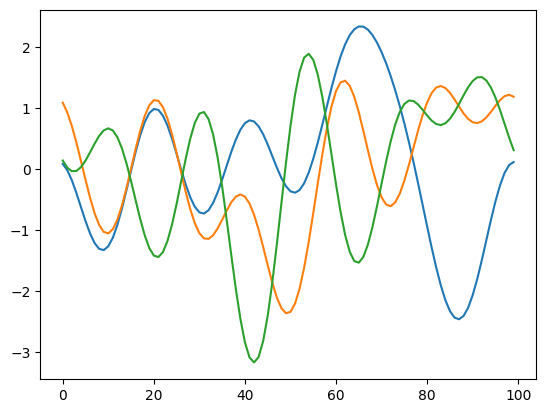

In [7]:
plt.plot(train_ic_set[:3, 0, :].T);

Rollout the initial conditions of the training dataset

In [8]:
train_trj_set = jax.vmap(
    ex.rollout(reference_stepper, TRAIN_TEMPORAL_HORIZON, include_init=True)
)(train_ic_set)
# (TRAIN_N_SAMPLES, TRAIN_TEMPORAL_HORIZON + 1, 1, N)
train_trj_set.shape

(200, 51, 1, 100)

Plot the training trajectories as spatial-temporal plots. One can see that
within the first 5-10 time steps, the typical Burgers shocks develop which then
propagate. Over time, the state dissipates.

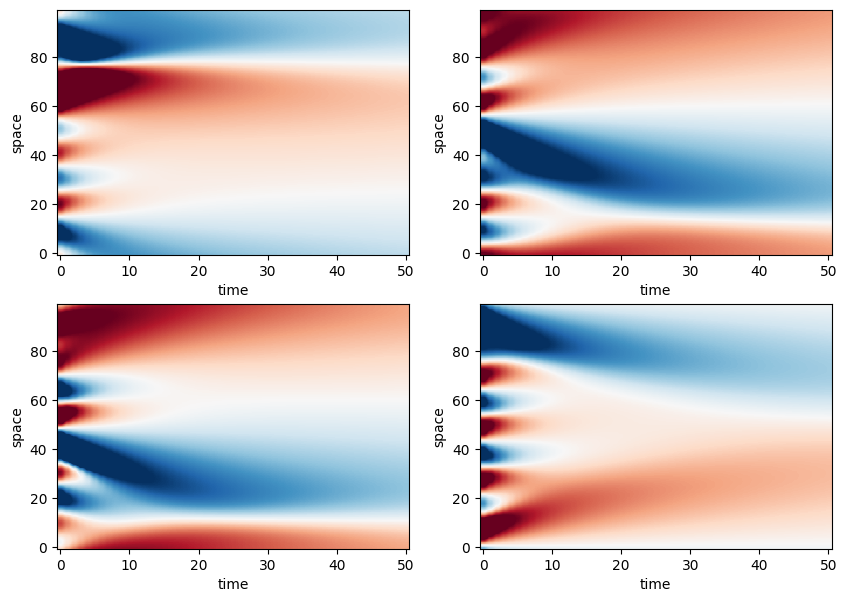

In [9]:
fig, ax_s = plt.subplots(2, 2, figsize=(10, 7))
for i, ax in enumerate(ax_s.ravel()):
    ax.imshow(
        train_trj_set[i, :, 0, :].T,
        cmap="RdBu_r",
        vmin=-1,
        vmax=1,
        aspect="auto",
        origin="lower",
    )
    ax.set_xlabel("time")
    ax.set_ylabel("space")

Repeat initial condition set generation and rollout for the validation set.

In [10]:
val_ic_set = ex.build_ic_set(
    IC_GENERATOR,
    num_points=NUM_POINTS,
    num_samples=VAL_NUM_SAMPLES,
    key=jax.random.PRNGKey(VAL_SEED),
)
val_trj_set = jax.vmap(
    ex.rollout(reference_stepper, VAL_TEMPORAL_HORIZON, include_init=True)
)(val_ic_set)

Investigating the shape of training data `(num_samples, num_timesteps, 1,
num_points)` we essentially have 2 "batch axes". To train with lagged windows of
size 2, we have slice those windows out the `num_timesteps` axis. This is what
the function `ex.stack_sub_trajectories` does. We apply it with `jax.vmap` to
vectorize over the `num_samples` axis. The configuration `in_axes=(0, None)` is
relevant to vectorize over the data input and not over the prescribed window
length of `2`.

In [11]:
# sub trajectories are or length 2 (corresponding to an input and output)
train_trj_set_substacked = jax.vmap(ex.stack_sub_trajectories, in_axes=(0, None))(
    train_trj_set, 2
)
# (TRAIN_N_SAMPLES, n_sub_trj_s, 2, 1, N)
train_trj_set_substacked.shape

(200, 50, 2, 1, 100)

Using the `jnp.concatenate` function to merge into one batch axis. The returning
data array has a very typical format of `(num_windws, window_length,
num_channels, ...)` with the `...` indicating an arbitrary number of spatial
dimensions. Here, we have one spatial axis of size `num_points`. Note that we
need a window length of 2 to do one-step supervised training to have both an
input and a target.

In [12]:
# Merge the two batch axes (samples & sub trajectories)
train_set = jnp.concatenate(train_trj_set_substacked)
# (TRAIN_N_SAMPLES * n_sub_trj_s, 2, 1, N)
train_set.shape

(10000, 2, 1, 100)

Let's visualize the first (zeroth) window

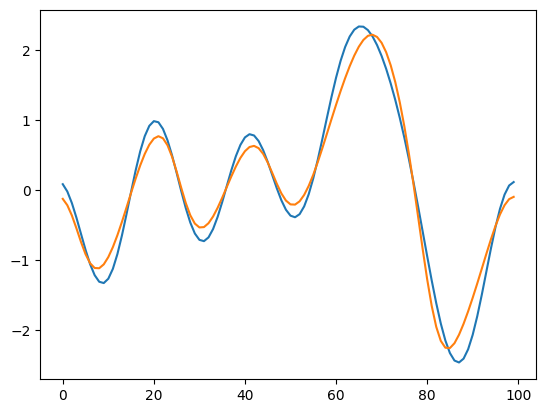

In [13]:
plt.plot(train_set[0, :, 0, :].T)

## 2. Model Definition

Below is a simple feed-forward convolutional network with periodic padding and
hard-coded tanh activation. The user can adjust the number of hidden layers and
their sizes. `num_hidden_layers=0` refers to a linear kernel=3 convolution with
a bias.

In [14]:
class SimplePeriodicConvNet(eqx.Module):
    conv_layers: List[eqx.nn.Conv1d]

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        hidden_width: int,
        num_hidden_layers: int,
        *,
        key,
    ):
        channel_list = (
            [in_channels] + [hidden_width] * num_hidden_layers + [out_channels]
        )

        self.conv_layers = []

        for fan_in, fan_out in zip(channel_list[:-1], channel_list[1:]):
            subkey, key = jr.split(key)
            self.conv_layers.append(
                eqx.nn.Conv1d(
                    fan_in,
                    fan_out,
                    kernel_size=3,
                    key=subkey,
                )
            )

    def periodic_padding(
        self,
        x,
    ):
        # padding over    channels space
        return jnp.pad(x, ((0, 0), (1, 1)), mode="wrap")

    def __call__(
        self,
        x,
    ):
        for conv_layer in self.conv_layers[:-1]:
            x = self.periodic_padding(x)
            x = conv_layer(x)
            x = jax.nn.tanh(x)

        x = self.periodic_padding(x)
        x = self.conv_layers[-1](x)
        return x

Sample initialization for a sanity check of the model

In [15]:
neural_stepper = SimplePeriodicConvNet(1, 1, 32, 5, key=jr.PRNGKey(INIT_SEED))
neural_stepper

SimplePeriodicConvNet(
  conv_layers=[
    Conv1d(
      num_spatial_dims=1,
      weight=f32[32,1,3],
      bias=f32[32,1],
      in_channels=1,
      out_channels=32,
      kernel_size=(3,),
      stride=(1,),
      padding=((0, 0),),
      dilation=(1,),
      groups=1,
      use_bias=True
    ),
    Conv1d(
      num_spatial_dims=1,
      weight=f32[32,32,3],
      bias=f32[32,1],
      in_channels=32,
      out_channels=32,
      kernel_size=(3,),
      stride=(1,),
      padding=((0, 0),),
      dilation=(1,),
      groups=1,
      use_bias=True
    ),
    Conv1d(
      num_spatial_dims=1,
      weight=f32[32,32,3],
      bias=f32[32,1],
      in_channels=32,
      out_channels=32,
      kernel_size=(3,),
      stride=(1,),
      padding=((0, 0),),
      dilation=(1,),
      groups=1,
      use_bias=True
    ),
    Conv1d(
      num_spatial_dims=1,
      weight=f32[32,32,3],
      bias=f32[32,1],
      in_channels=32,
      out_channels=32,
      kernel_size=(3,),
      stride=(1

Let's see what the network predicts with its initial parameter state

In [16]:
initial_neural_trj_set = jax.vmap(
    ex.rollout(neural_stepper, VAL_TEMPORAL_HORIZON, include_init=True)
)(val_ic_set)

As expected, the prediction is rather bad in the sense of accuracy but it is
also a good start for training. ;)

Text(0.5, 1.0, 'Initial neural')

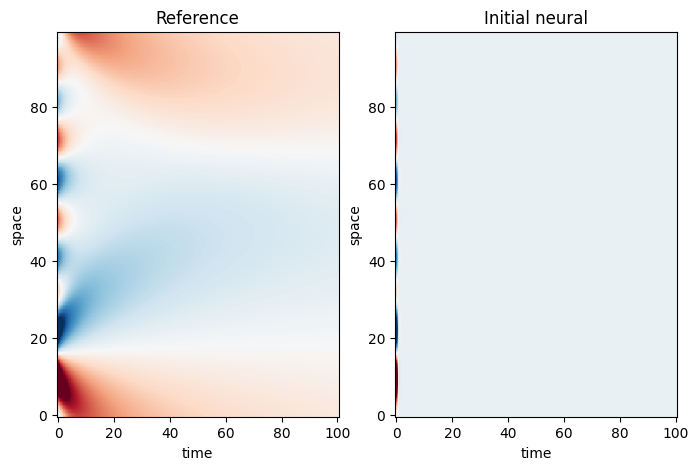

In [17]:
fig, ax_s = plt.subplots(1, 2, figsize=(8, 5))
ax_s[0].imshow(
    val_trj_set[0, :, 0, :].T,
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    aspect="auto",
    origin="lower",
)
ax_s[0].set_xlabel("time")
ax_s[0].set_ylabel("space")
ax_s[0].set_title("Reference")
ax_s[1].imshow(
    initial_neural_trj_set[0, :, 0, :].T,
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    aspect="auto",
    origin="lower",
)
ax_s[1].set_xlabel("time")
ax_s[1].set_ylabel("space")
ax_s[1].set_title("Initial neural")

## 3. Training

Below is a simple JAX-based dataloader

In [18]:
def dataloader(
    data,
    *,
    batch_size: int,
    key,
):
    n_samples = data.shape[0]

    n_batches = int(jnp.ceil(n_samples / batch_size))

    permutation = jax.random.permutation(key, n_samples)

    for batch_id in range(n_batches):
        start = batch_id * batch_size
        end = min((batch_id + 1) * batch_size, n_samples)

        batch_indices = permutation[start:end]

        sub_data = data[batch_indices]

        yield sub_data

Below is a straightforward training loop in JAX using the prescribed optimizer.
Notice, how we slice the input and target out of one data batch as the first
operation in the loss function.

Training should be $\sim 10s$ on a GPU.

In [19]:
neural_stepper = SimplePeriodicConvNet(1, 1, 32, 5, key=jr.PRNGKey(5))

opt_state = OPTIMIZER.init(eqx.filter(neural_stepper, eqx.is_array))


def loss_fn(model, batch):
    x, y = batch[:, 0], batch[:, 1]
    y_hat = jax.vmap(model)(x)
    return jnp.mean(jnp.square(y - y_hat))


@eqx.filter_jit
def step_fn(model, state, batch):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, batch)
    updates, new_state = OPTIMIZER.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss


shuffle_key = jr.PRNGKey(SHUFFLE_SEED)
train_loss_history = []

for epoch in tqdm(range(NUM_EPOCHS), position=0):
    shuffle_key, subkey = jr.split(shuffle_key)
    for batch in dataloader(train_set, batch_size=BATCH_SIZE, key=subkey):
        neural_stepper, opt_state, loss = step_fn(neural_stepper, opt_state, batch)
        train_loss_history.append(loss)

  0%|          | 0/50 [00:00<?, ?it/s]

The final state of training is very noisy (likely due to the small batch sizes
and a suboptimal learning rate scheduling), but we still sufficiently trained
the network -> Reduced the loss ~4 orders of magnitude.

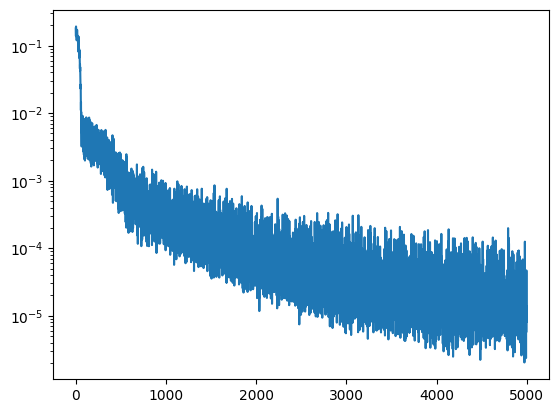

In [20]:
plt.plot(train_loss_history)
plt.yscale("log")

Let's use the trained neural predictor to rollout the validation intial conditions

In [21]:
trained_neural_prediction = jax.vmap(
    ex.rollout(neural_stepper, VAL_TEMPORAL_HORIZON, include_init=True)
)(val_ic_set)

A visual comparison with the validation reference reveils a close match

Text(0.5, 1.0, 'Trained neural')

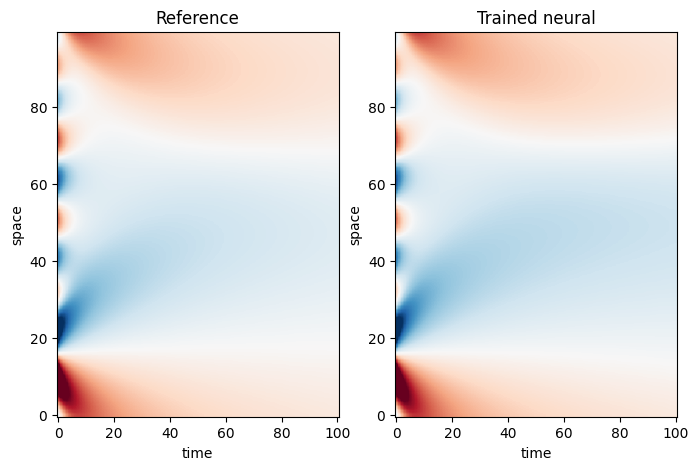

In [22]:
fig, ax_s = plt.subplots(1, 2, figsize=(8, 5))
ax_s[0].imshow(
    val_trj_set[0, :, 0, :].T,
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    aspect="auto",
    origin="lower",
)
ax_s[0].set_xlabel("time")
ax_s[0].set_ylabel("space")
ax_s[0].set_title("Reference")
ax_s[1].imshow(
    trained_neural_prediction[0, :, 0, :].T,
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    aspect="auto",
    origin="lower",
)
ax_s[1].set_xlabel("time")
ax_s[1].set_ylabel("space")
ax_s[1].set_title("Trained neural")

For a numerical assessment, we compute the normalized root-mean-squared error
(nRMSE) between the prediction and the reference for each sample and each time
step.

The `ex.metrics.nRMSE` takes two state arrays (consisting of the leading channel
dimension and an arbitrary number of spatial dimensions). We will apply two
`jax.vmap` to vectorize over both the sample and time axis.

In [23]:
# Compute normalized error rollout for trained network
error_trj_s = jax.vmap(jax.vmap(ex.metrics.nRMSE))(
    trained_neural_prediction, val_trj_set
)
# (VAL_N_SAMPLES, VAL_TEMPORAL_HORIZON + 1,)
error_trj_s.shape

(20, 101)

Let's visualize the nRMSE over time for each sample. Note that once the error
reaches the threshold of 1.0, the RMSE of the predicted state is of the same
order of magnitude of the reference state. This likely indicates that the
prediction diverged from the ground truth.

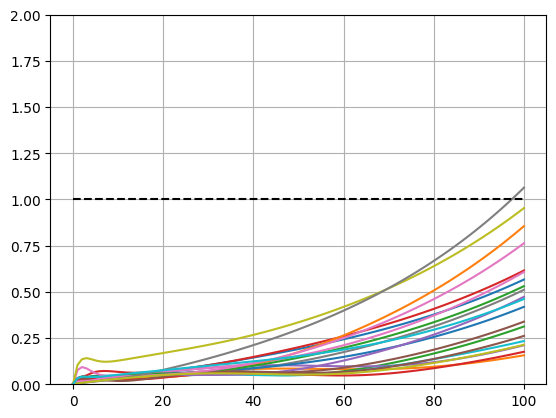

In [24]:
plt.plot(error_trj_s.T)
plt.hlines(1.0, 0, VAL_TEMPORAL_HORIZON, linestyles="dashed", color="black")
plt.ylim(0, 2)
plt.grid()